In [7]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

%matplotlib inline
import matplotlib.pyplot as plt
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

# Aim

We want to undersand the effect which including variance is having.

So natrually we are trying to answer the following:
- Why does having variance seem to improve method.
- What are the effects of differnt window sizes.
- What are the effects of worse variance models. 

On effects of worse variance models. 
Inital: On synthetic data
- Use your exp random walk and use differnt filters on the variance.
- Run multiple HACI -> focus on dual tail. 
- Compare. Using existing method and custom.

Thoughts:
- I think that it will be quite robust to errors in variance.
- I have an intuition that it will have some way of normalising if the errors are consistent.

To do:
- look at method. >
- get data, >
- get raw results. 
- compare. 

In [8]:
def create_hetroskedatic_var_data(length: int, model_error: float = 0.1, var_range: tuple = (0.5, 2)) -> tuple:
        '''Model error = 0.05, means the model is at most 5% wrong in either direction and uniformly between.'''  

        # Exponetial random walk of variances.

        exp_random_walk = np.random.normal(0, 0.1, length)
        true_variance_array = np.exp(np.cumsum(exp_random_walk))

        corresponding_normal = np.random.normal(0, true_variance_array, length)

        # Simulating the model error. 
        model_tolerence = model_error * true_variance_array
        distribution_arround_true = np.random.uniform(-1, 1, length) * model_tolerence
        model_variance_array = true_variance_array + distribution_arround_true

        time_series_normal = np.cumsum(corresponding_normal)

        # Now we need to return as xpred, varpred, y

        return (time_series_normal[:-1], model_variance_array[1:], time_series_normal[1:])

In [9]:
def create_changing_var_data(model_error_array, length, times, step: float = 0.1) -> tuple:
        '''This will take an array of model errors and return a time series with changing variance models.
        Times will be the number of dists it should make for each model error.
        
        returns dictionary containing the tuples of dists'''  

        return_dict = {key: [] for key in model_error_array}

        # Exponetial random walk of variances.
        # G
        exp_random_walk = np.random.normal(0, step, length)
        true_variance_array = np.exp(np.cumsum(exp_random_walk))
        corresponding_normal = np.random.normal(0, true_variance_array, length)

        time_series_normal = np.cumsum(corresponding_normal)

        def var_model_effect(model_error, variance_array):
            model_tolerence = model_error * variance_array
            distribution_arround_true = np.random.uniform(-1, 1, length) * model_tolerence
            model_variance_array = variance_array + distribution_arround_true

            return model_variance_array
             
        # Simulating the model error times times for each model error.
        for model_error in model_error_array:
            for _ in range(times):
                model_variance_array = var_model_effect(model_error, true_variance_array)
                return_dict[model_error].append((time_series_normal[:-1], model_variance_array[1:], time_series_normal[1:]))
        
        aci_data = (time_series_normal[:-1], time_series_normal[1:])
        
        return return_dict, aci_data

In [10]:
# Creating the data. 
times = 1
model_error_array = np.linspace(0.1, 0.5, 10)
model_error_data_dict, aci_data = create_changing_var_data(model_error_array, 1000, times)

In [11]:
instance = AdaptiveCP(0.1, 250)
method = AdaptiveCP.HACI_dual_tail
model_error_raw_results = {key: [] for key in model_error_array}



In [12]:
for key in model_error_data_dict:
    print(f'Running model error: {key}')
    for data in model_error_data_dict[key]:
        result = method(instance, data)
        model_error_raw_results[key].append(result)
    print(f'Finished model error: {key}')

#pickling the model_error_raw_results
import pickle
with open(f'model_error_raw_data{times}.pkl', 'wb') as f:
    pickle.dump(model_error_data_dict, f)
    
with open(f'model_error_raw_results{times}.pkl', 'wb') as f:
    pickle.dump(model_error_raw_results, f)


Running model error: 0.1
Finished model error: 0.1
Running model error: 0.14444444444444446
Finished model error: 0.14444444444444446
Running model error: 0.18888888888888888
Finished model error: 0.18888888888888888
Running model error: 0.23333333333333334
Finished model error: 0.23333333333333334
Running model error: 0.2777777777777778
Finished model error: 0.2777777777777778
Running model error: 0.32222222222222224
Finished model error: 0.32222222222222224
Running model error: 0.3666666666666667
Finished model error: 0.3666666666666667
Running model error: 0.4111111111111111
Finished model error: 0.4111111111111111
Running model error: 0.4555555555555556
Finished model error: 0.4555555555555556
Running model error: 0.5
Finished model error: 0.5


10 minutes for a single run that is abominable. You coudld at most speed this up by like 2 times. 

In [13]:
coverage_results = {key: result[0]['realised_interval_coverage'] for key, result in model_error_raw_results.items()}
length_results = {key: result[0]['average_prediction_interval'] for key, result in model_error_raw_results.items()}

In [14]:
err_t = {str(key): pd.Series(result[0]['error_t_list']).rolling(50).mean() for key, result in model_error_raw_results.items()}


## Correlation between Interval widths and model_error

In [15]:
# Testing the correlation between model error and interval length.
length_results = [(key, result[0]['average_prediction_interval']) for key, result in model_error_raw_results.items()]
length_results = pd.DataFrame(length_results, columns=['Model Error', 'Interval Length'])
print(length_results.corr())

                 Model Error  Interval Length
Model Error         1.000000         0.520701
Interval Length     0.520701         1.000000


They are correlated.

## Correlating between coverage and model_error.

In [16]:
## Correlation between interval widths and absolute_error
abs_coverage_differnce = [(key, abs(1 - result[0]['realised_interval_coverage'] - 0.1)) for key, result in model_error_raw_results.items()]
abs_coverage_differnce = pd.DataFrame(abs_coverage_differnce, columns=['Model Error', 'Abs Coverage Difference'])
print(abs_coverage_differnce.corr())

                         Model Error  Abs Coverage Difference
Model Error                 1.000000                 0.615104
Abs Coverage Difference     0.615104                 1.000000


They are not correlated. 
- ACI update is able to kick in, this likley means performs more like aci. 
- if you wernt using the last prediction as your next step then you would likely get worse results, as in the current scenario. Higher variance should directly correlate with a higher score hence it can be modeled well. However may need to pay some thought.

## Correlation between coverage and variance of the coverage. 

In [17]:
coverage_rolling_dict = {key: pd.Series(result[0]['error_t_list']).rolling(100).mean() for key, result in model_error_raw_results.items()}
coverage_var = [(key, result.dropna().var()) for key, result in coverage_rolling_dict.items()]
ncoverage_var = [(key, np.var(result[0]['error_t_list'])) for key, result in model_error_raw_results.items()]

coverage_var = pd.DataFrame(coverage_var, columns=['Model Error', 'Coverage Variance'])
ncoverage_var = pd.DataFrame(ncoverage_var, columns=['Model Error', 'Coverage Variance'])

print(coverage_var.corr())
print(ncoverage_var.corr())


                   Model Error  Coverage Variance
Model Error           1.000000           0.779921
Coverage Variance     0.779921           1.000000
                   Model Error  Coverage Variance
Model Error           1.000000           0.606246
Coverage Variance     0.606246           1.000000


coverage variance is correlated with the model_error. 

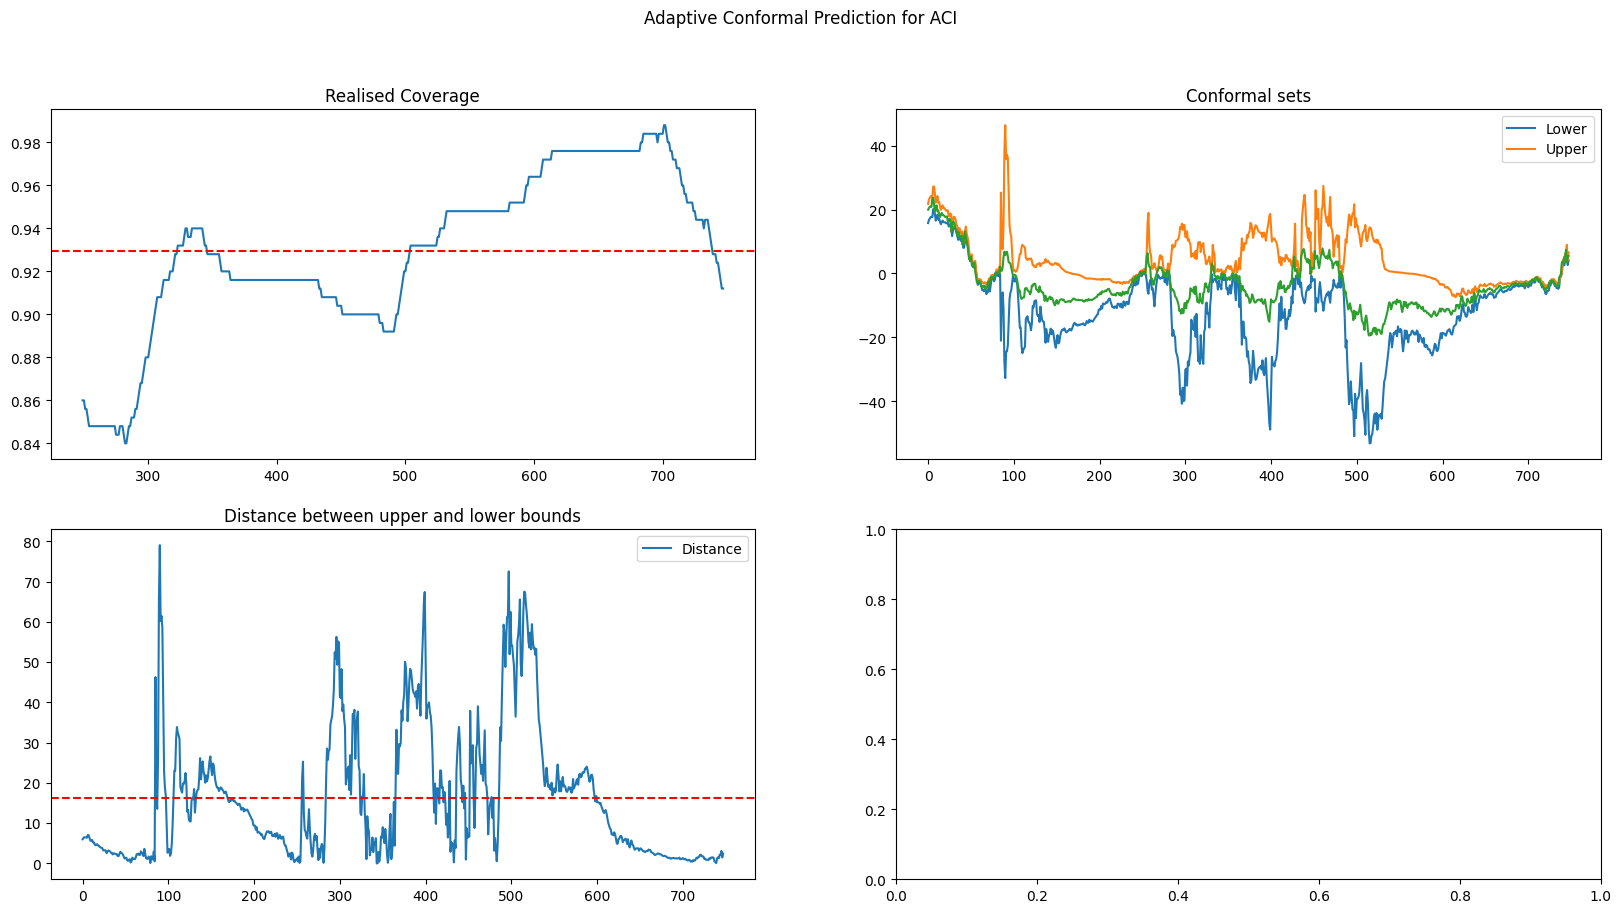

In [18]:
aci_result = instance.ACI(aci_data, 0.005)
ACP_plots.one_plot(aci_result, aci_data[1])

It is shocking in comparison

0.1
3.869893054384385 0.8960400801603207


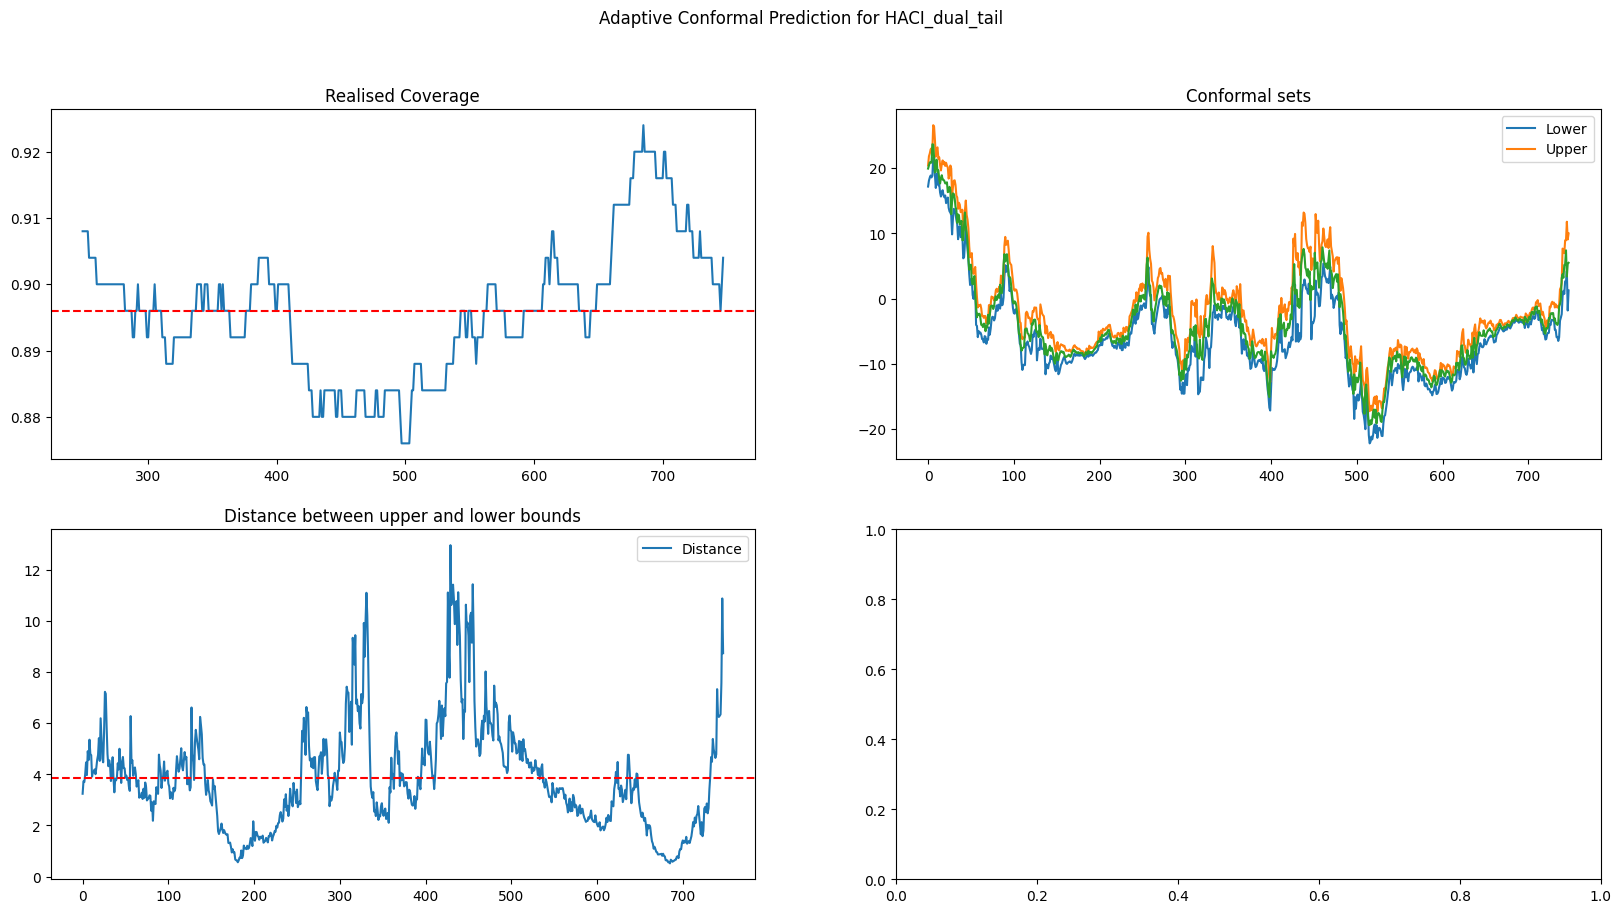

0.14444444444444446
4.026220339885097 0.8924729458917835


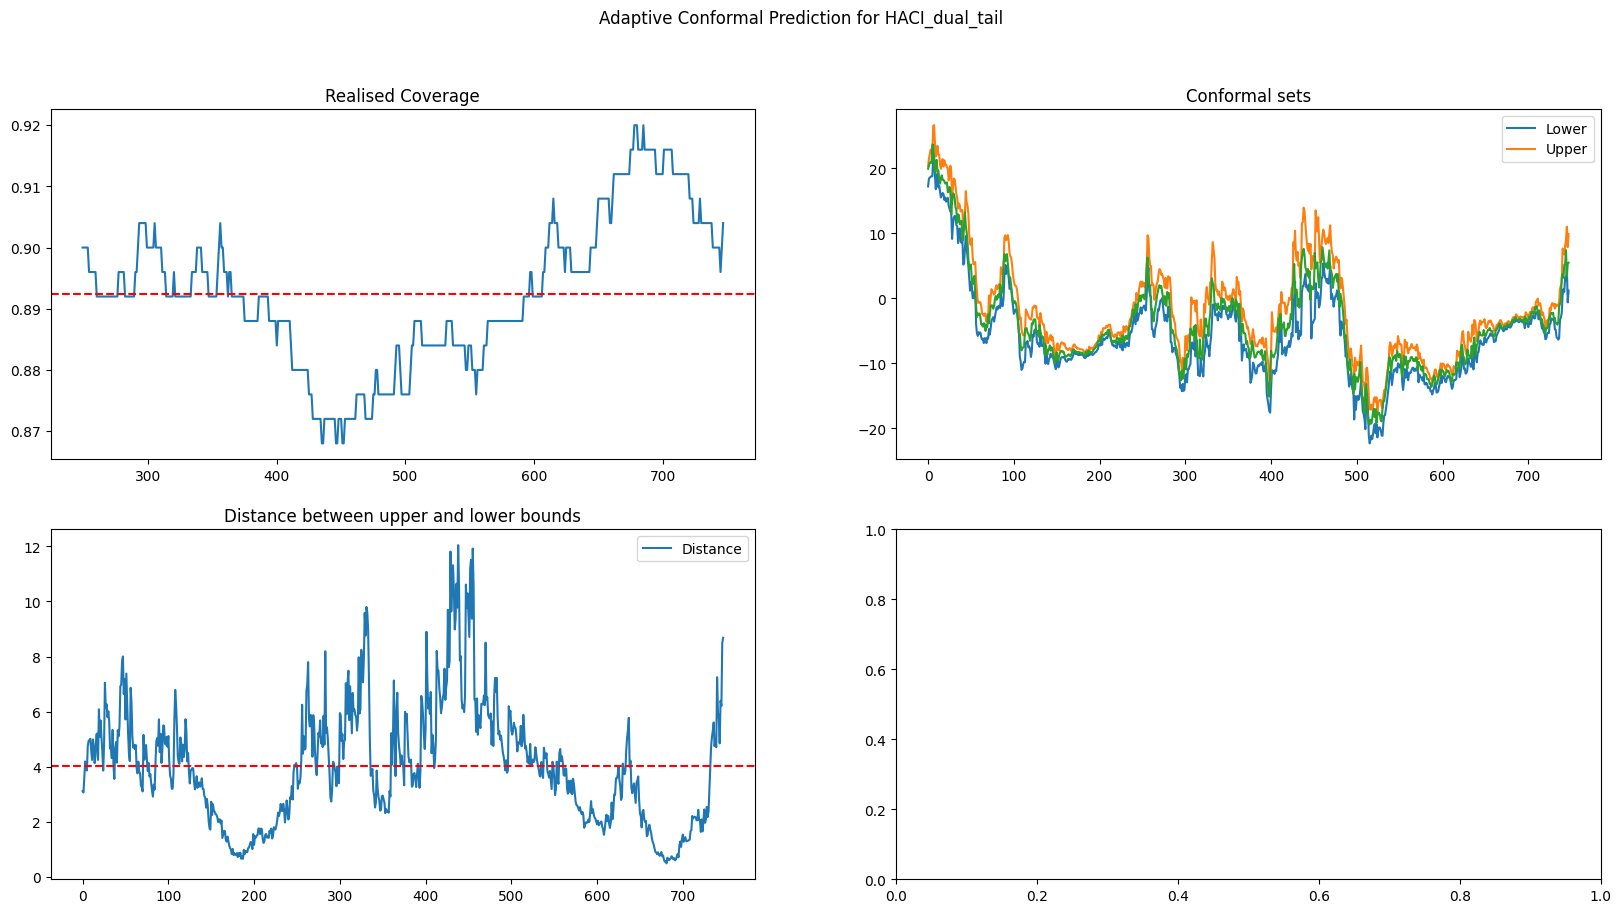

0.18888888888888888
3.8441152608022207 0.896753507014028


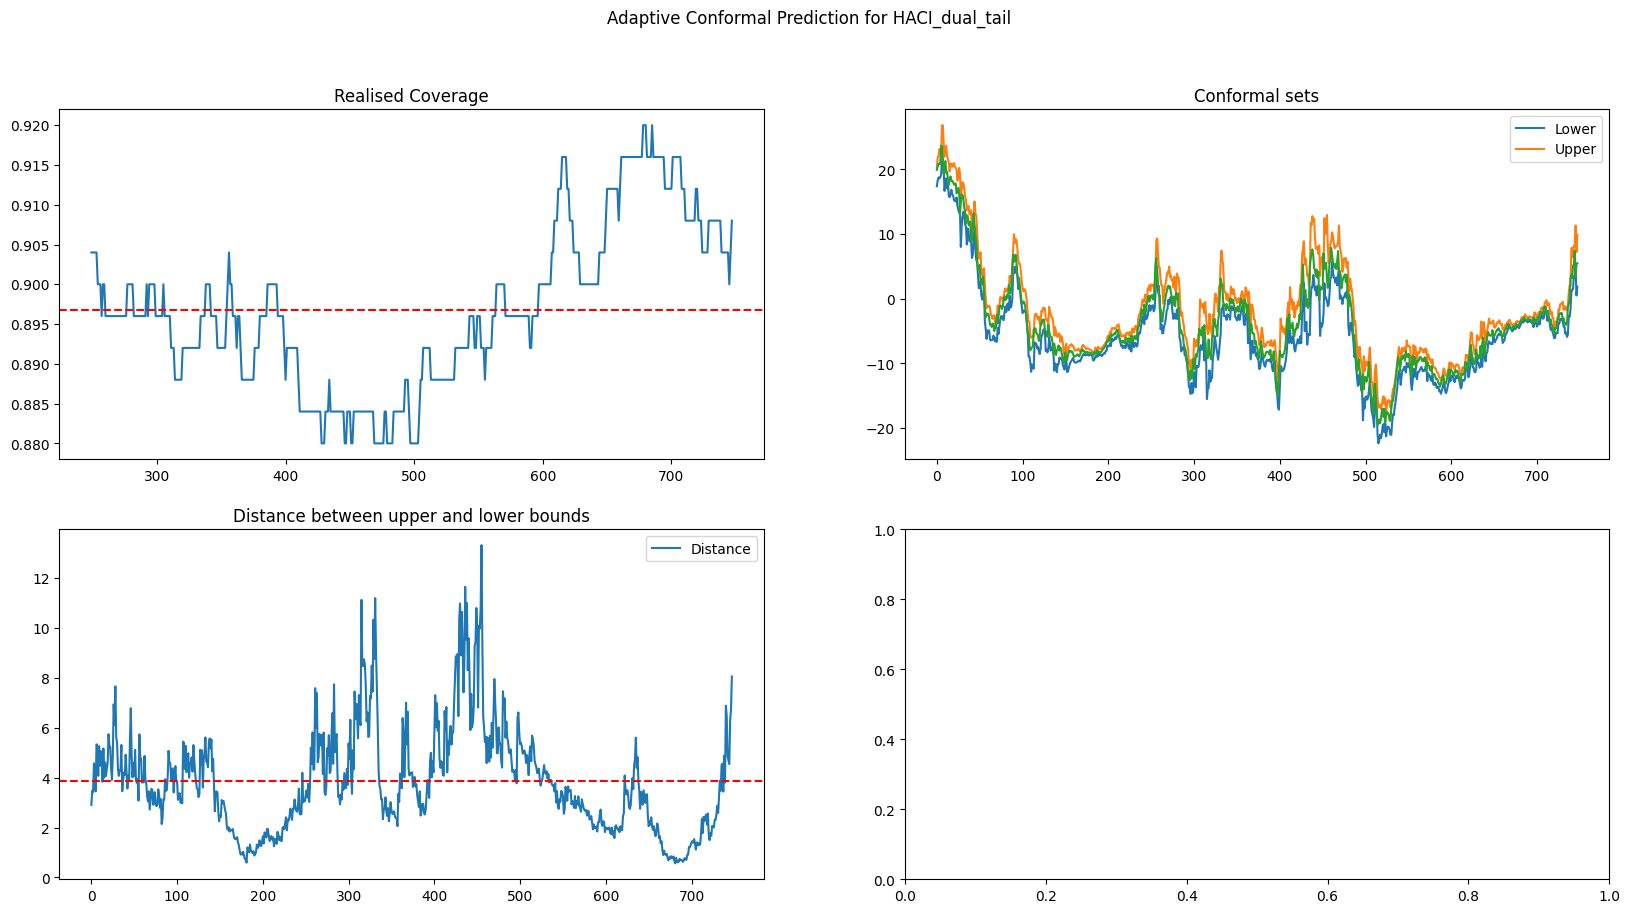

0.23333333333333334
4.039916153957931 0.8973547094188377


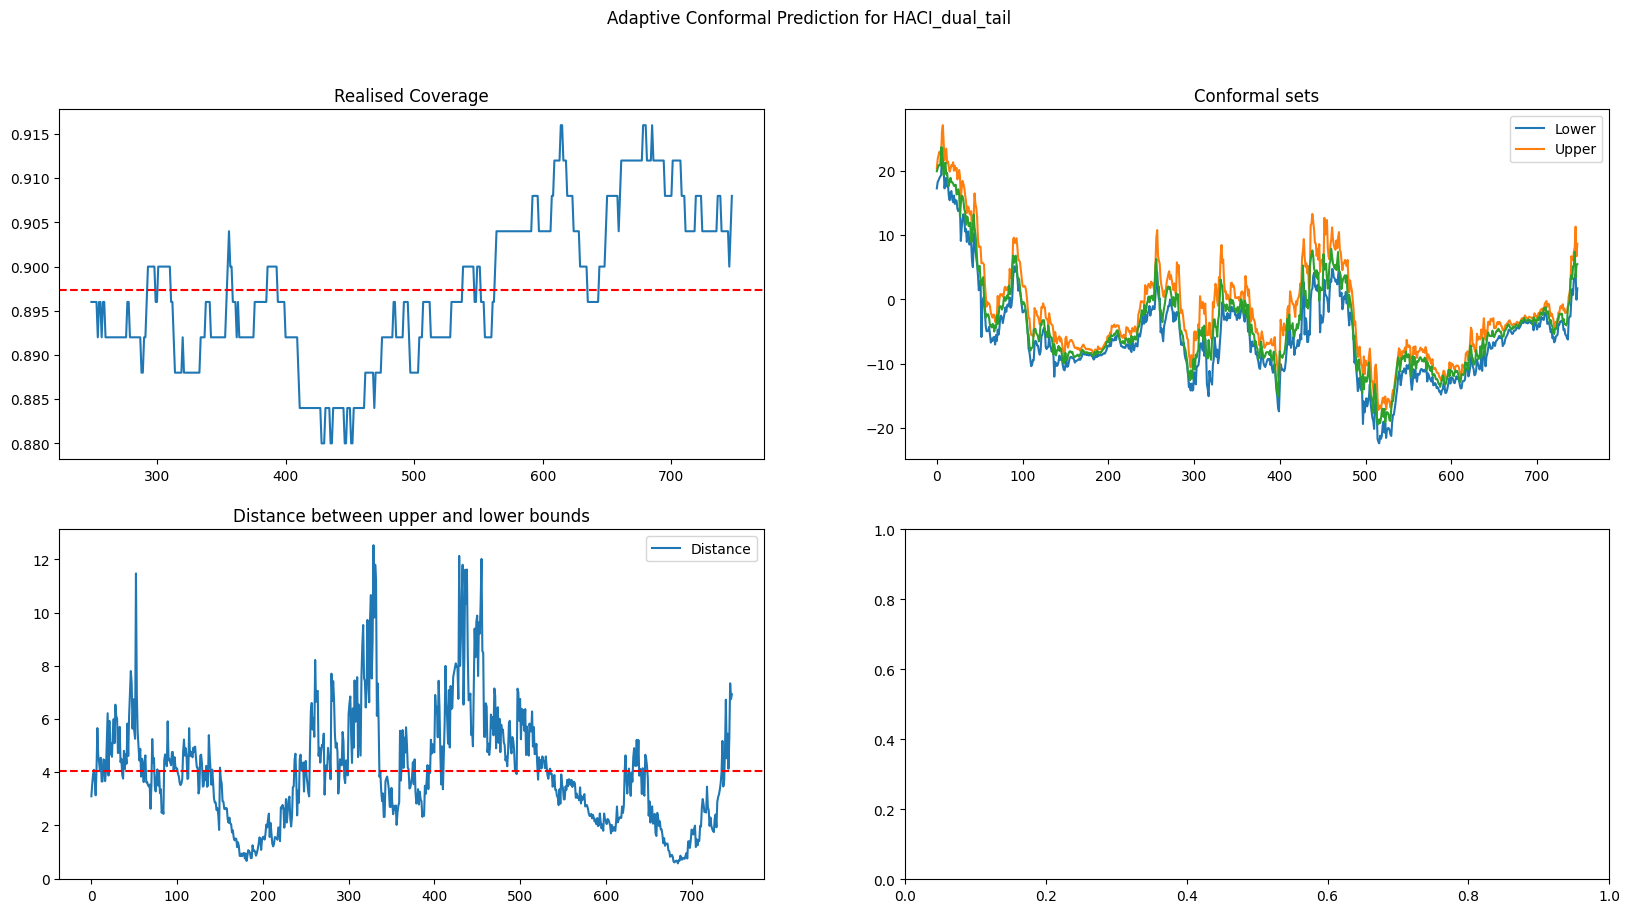

0.2777777777777778
3.9608609198354854 0.8953026052104208


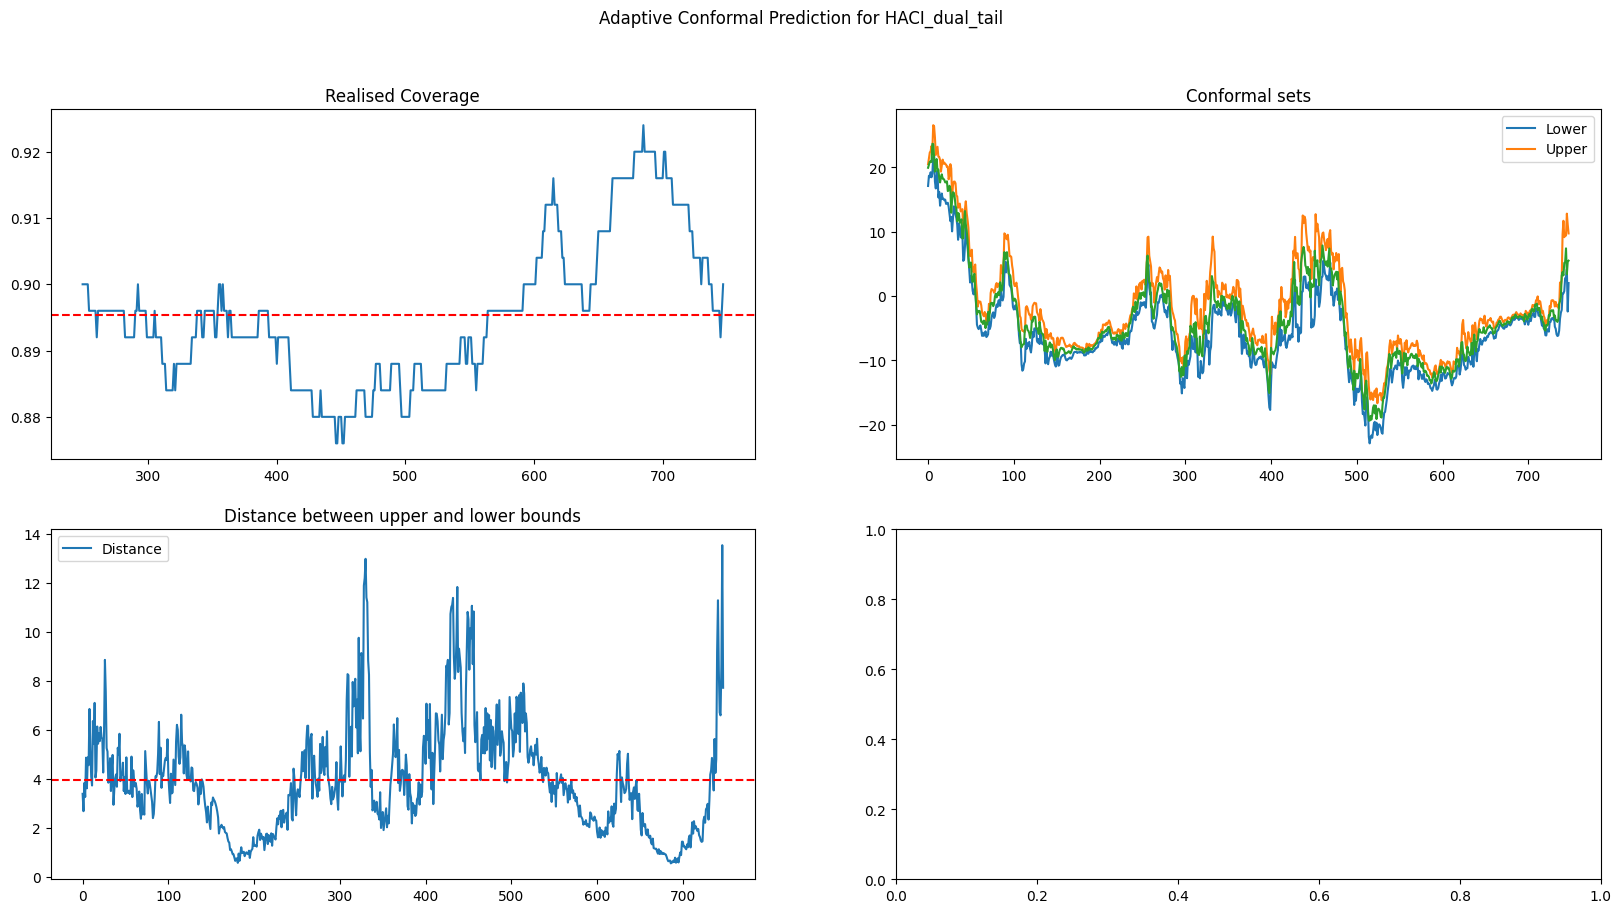

0.32222222222222224
4.052164352187719 0.8936753507014028


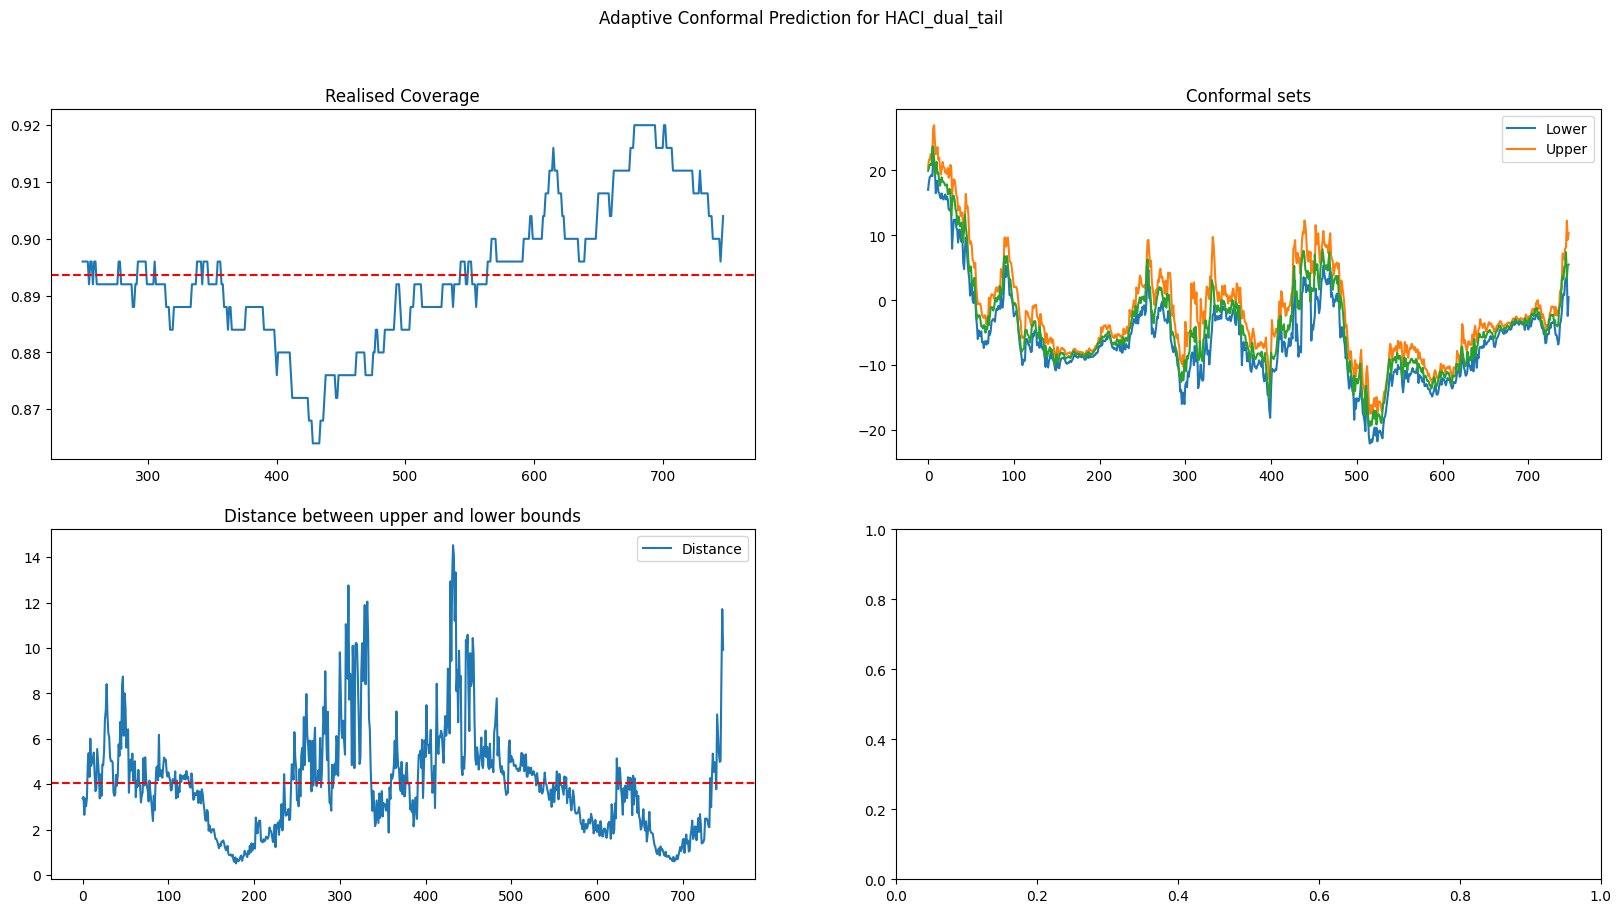

0.3666666666666667
3.9205219779894085 0.895310621242485


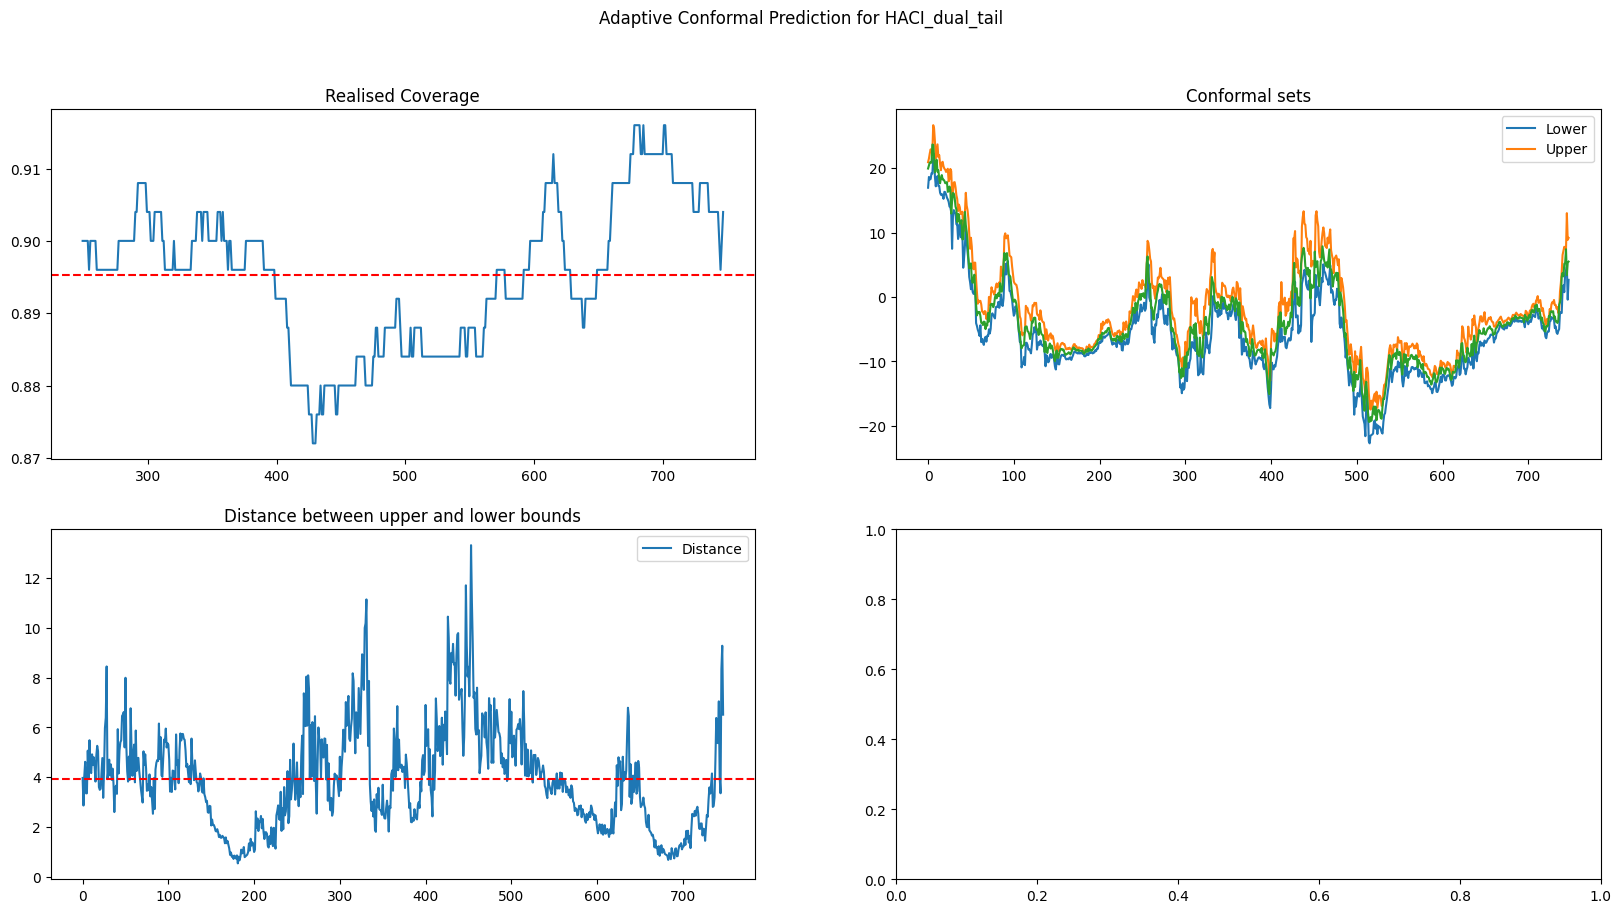

0.4111111111111111
4.005611291600756 0.8924328657314629


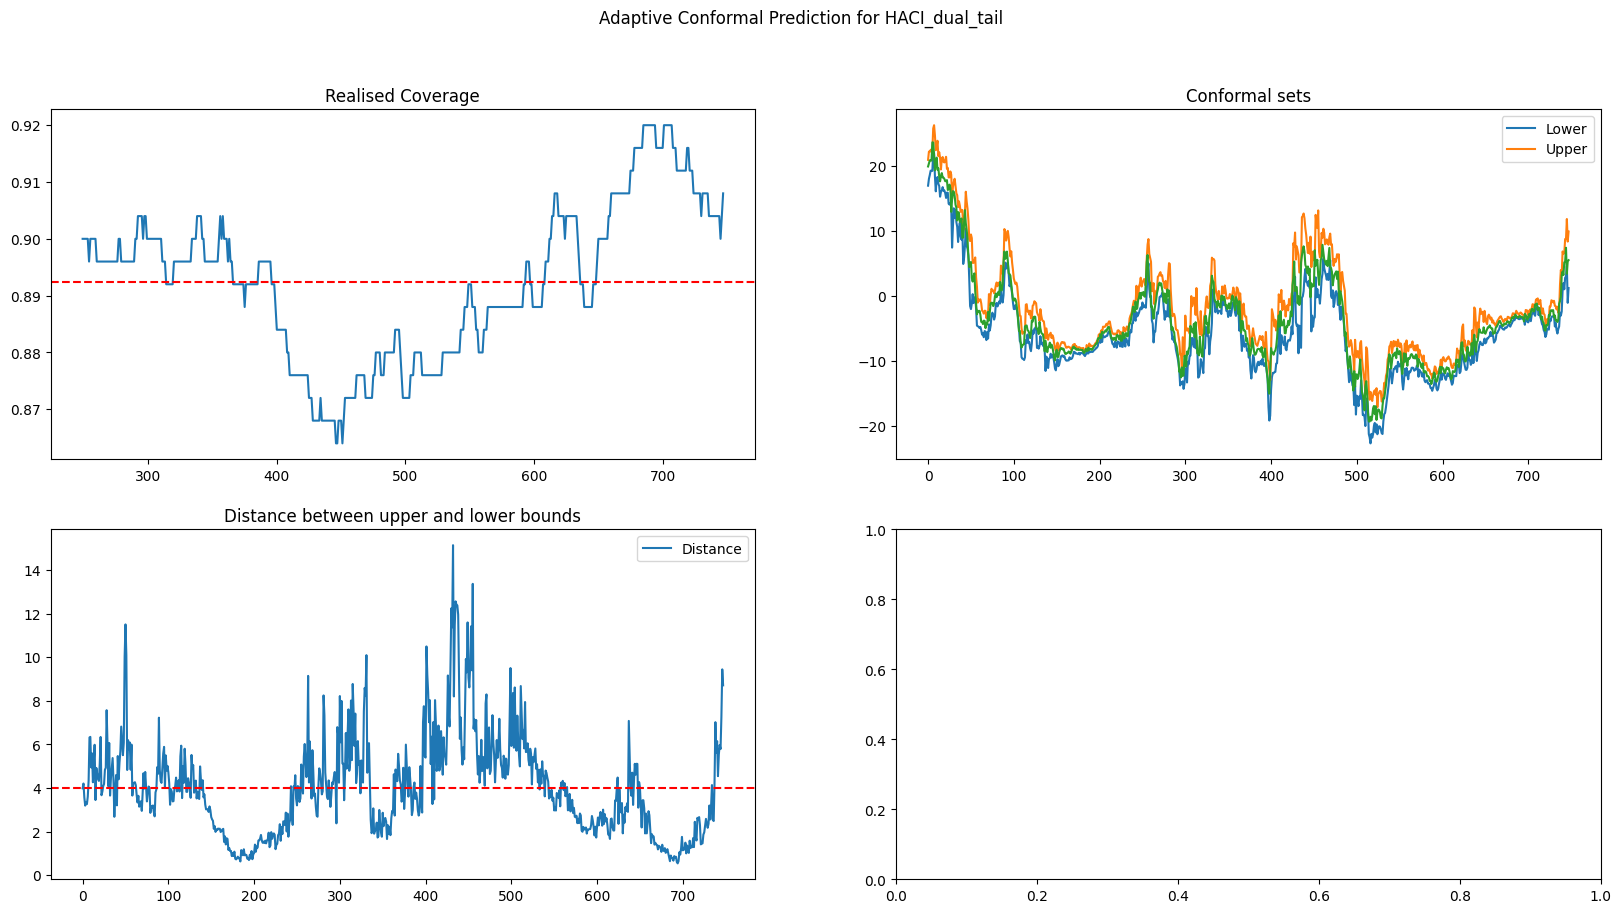

0.4555555555555556
3.9840115631328445 0.891623246492986


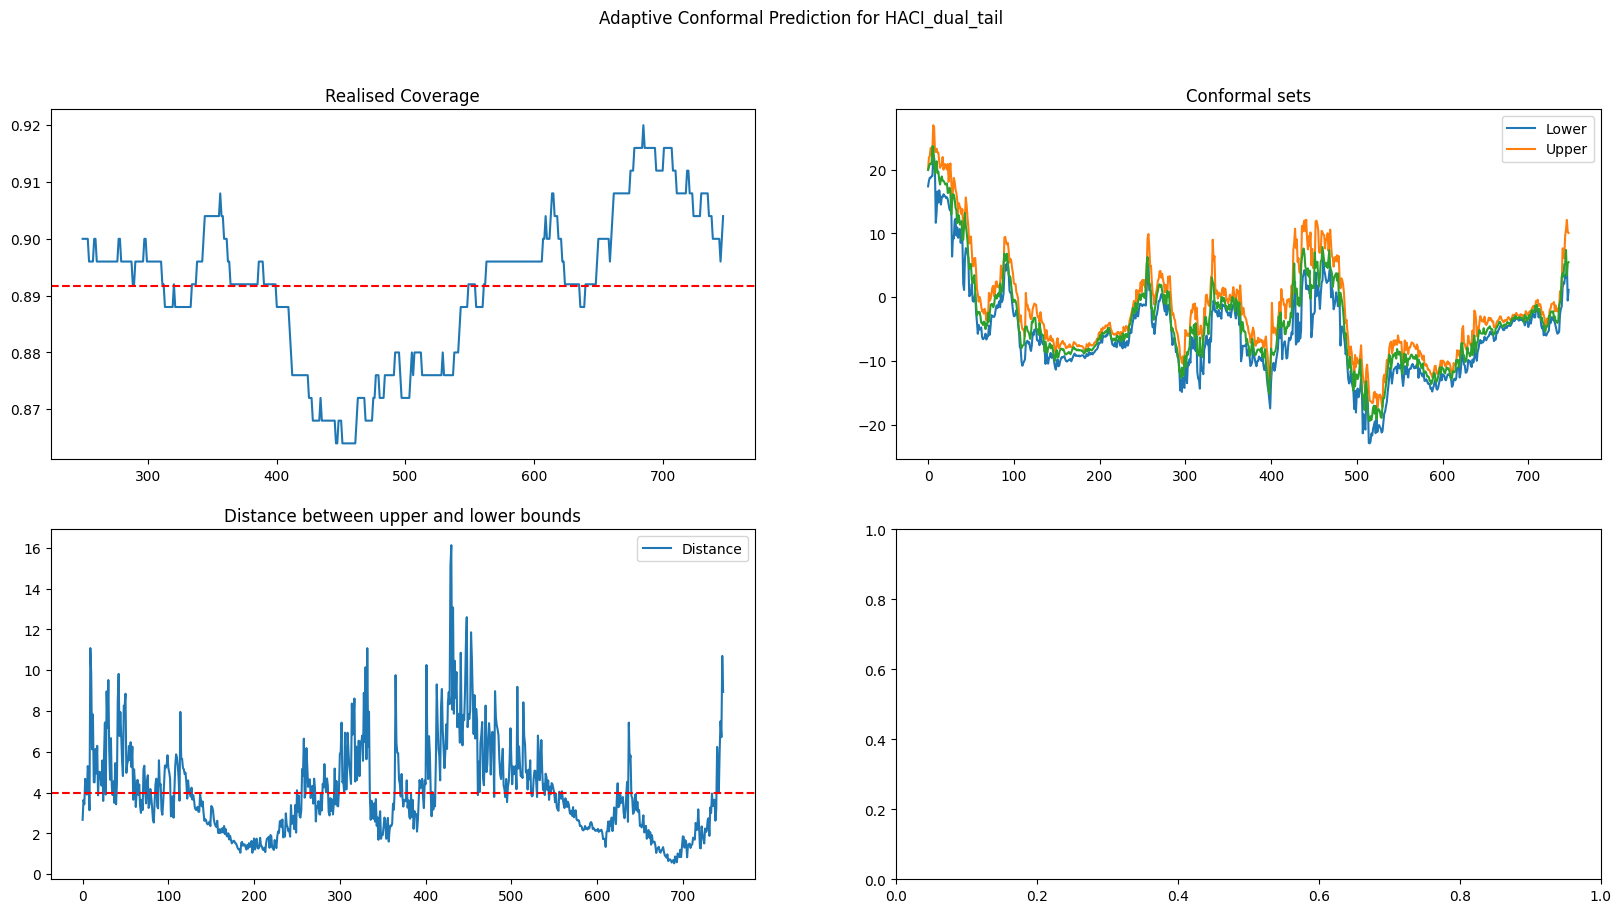

0.5
4.1023919457384315 0.892184368737475


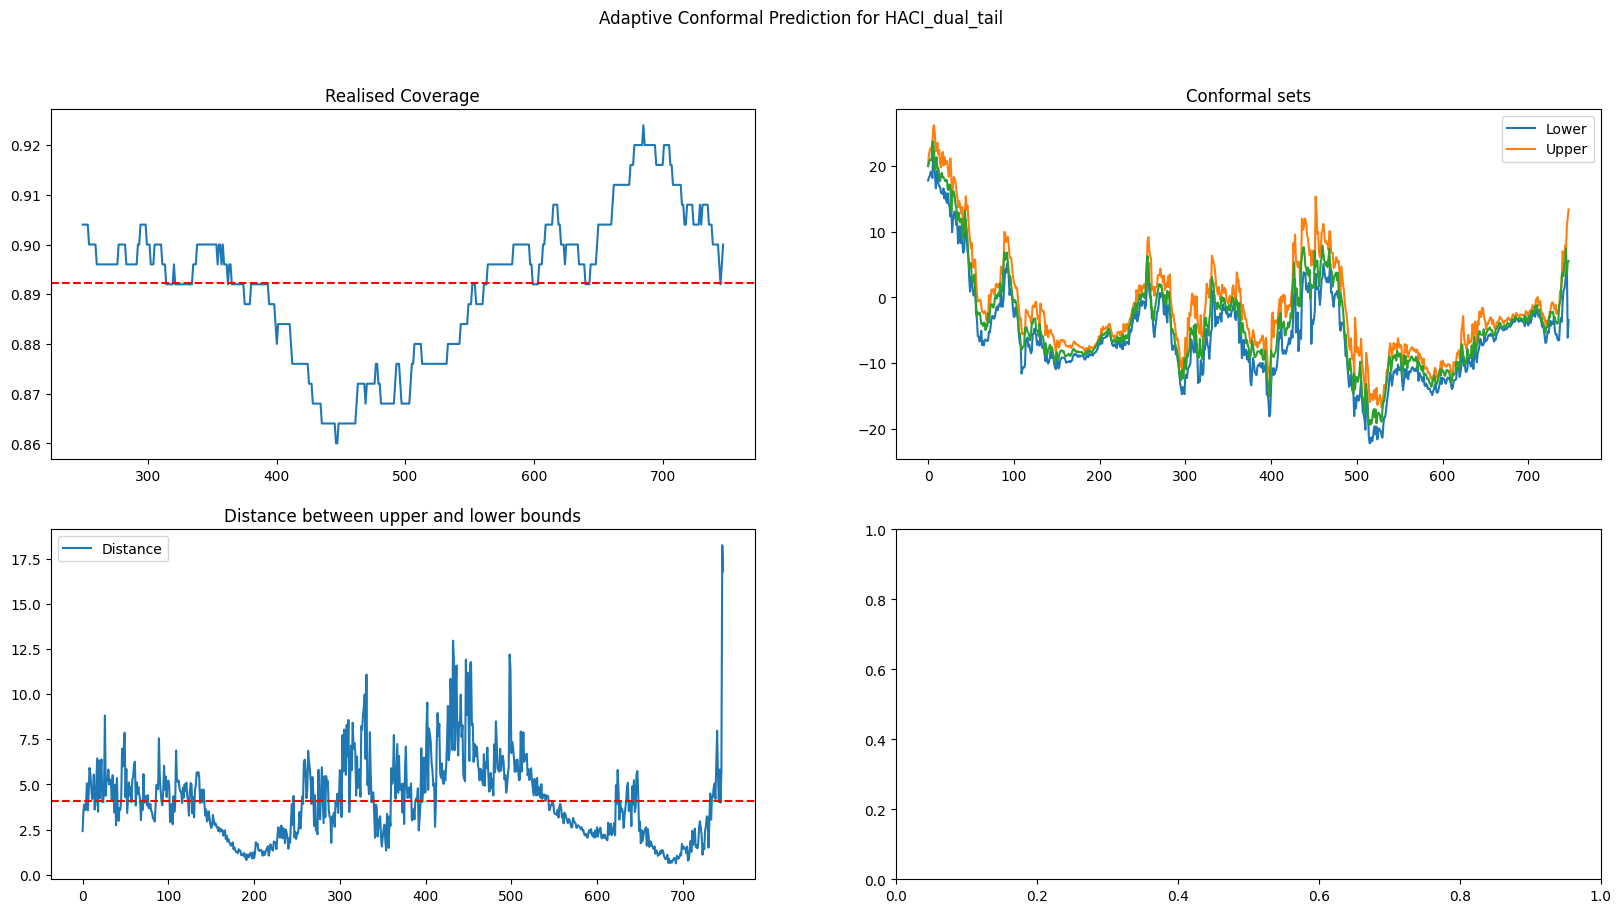

In [19]:
# Simple plot for each.
for key, item in model_error_raw_results.items():
    for result in item:
        print(key)
        print(result['average_prediction_interval'], result['realised_interval_coverage'])
        ACP_plots.one_plot(result, aci_data[1])
        plt.show()

Visual Observations:
- The worse the model is then the more spread the coverage becomes.
    - 